In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit import transpile
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.providers.basic_provider import BasicProvider

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [3]:
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target

In [4]:
d = df
X = d.drop(['target'], axis=1)
y = d['target']

In [5]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [6]:
pca = PCA(n_components=4)
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.44272026 0.18971182 0.09393163 0.06602135]


In [7]:
X = MinMaxScaler().fit_transform(X)

In [8]:
algorithm_globals.random_seed = 123

In [9]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y, train_size=0.8, random_state=algorithm_globals.random_seed)

In [10]:
num_features = train_features.shape[1]

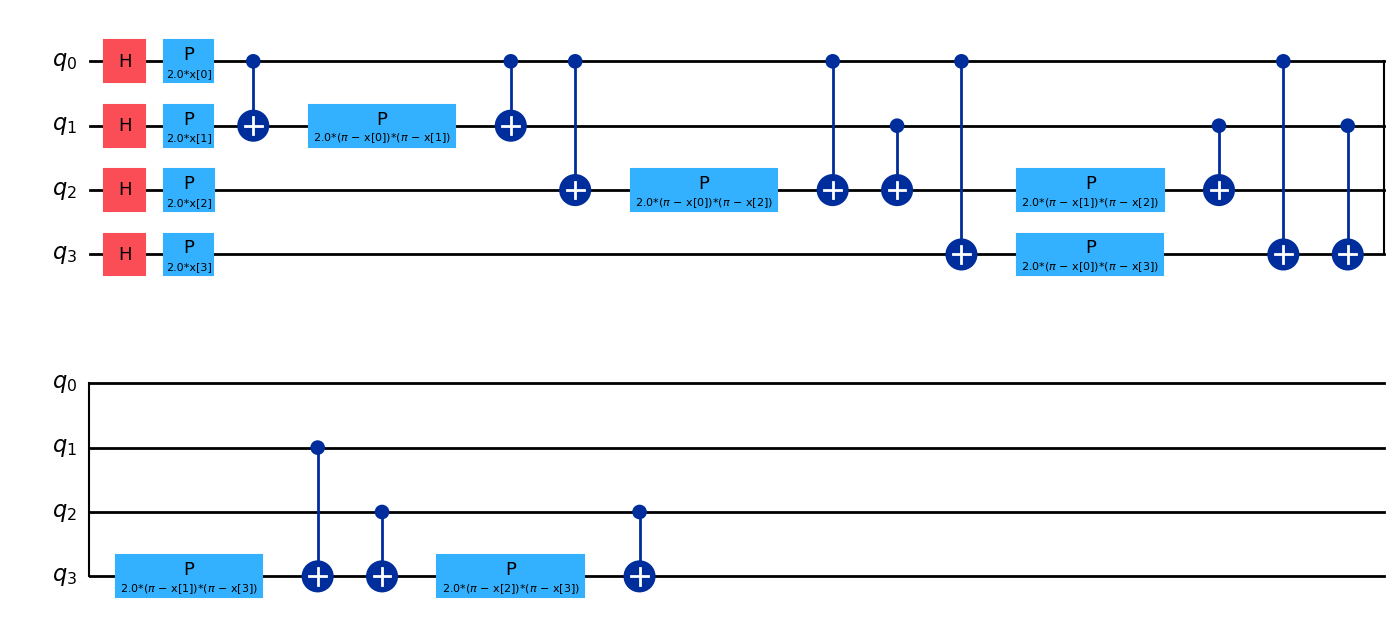

In [11]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output='mpl', fold=20, filename='featuremap')

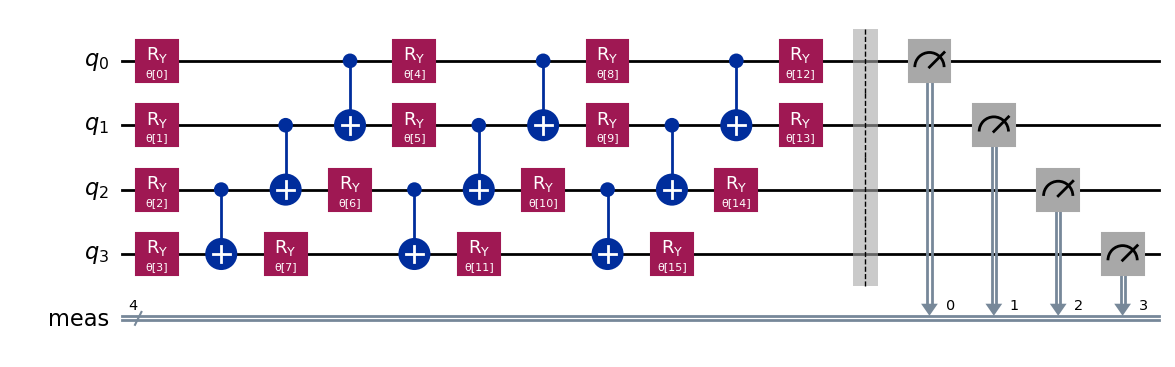

In [12]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.measure_all()
ansatz.decompose().draw(output='mpl', fold=20, filename='ansatz')

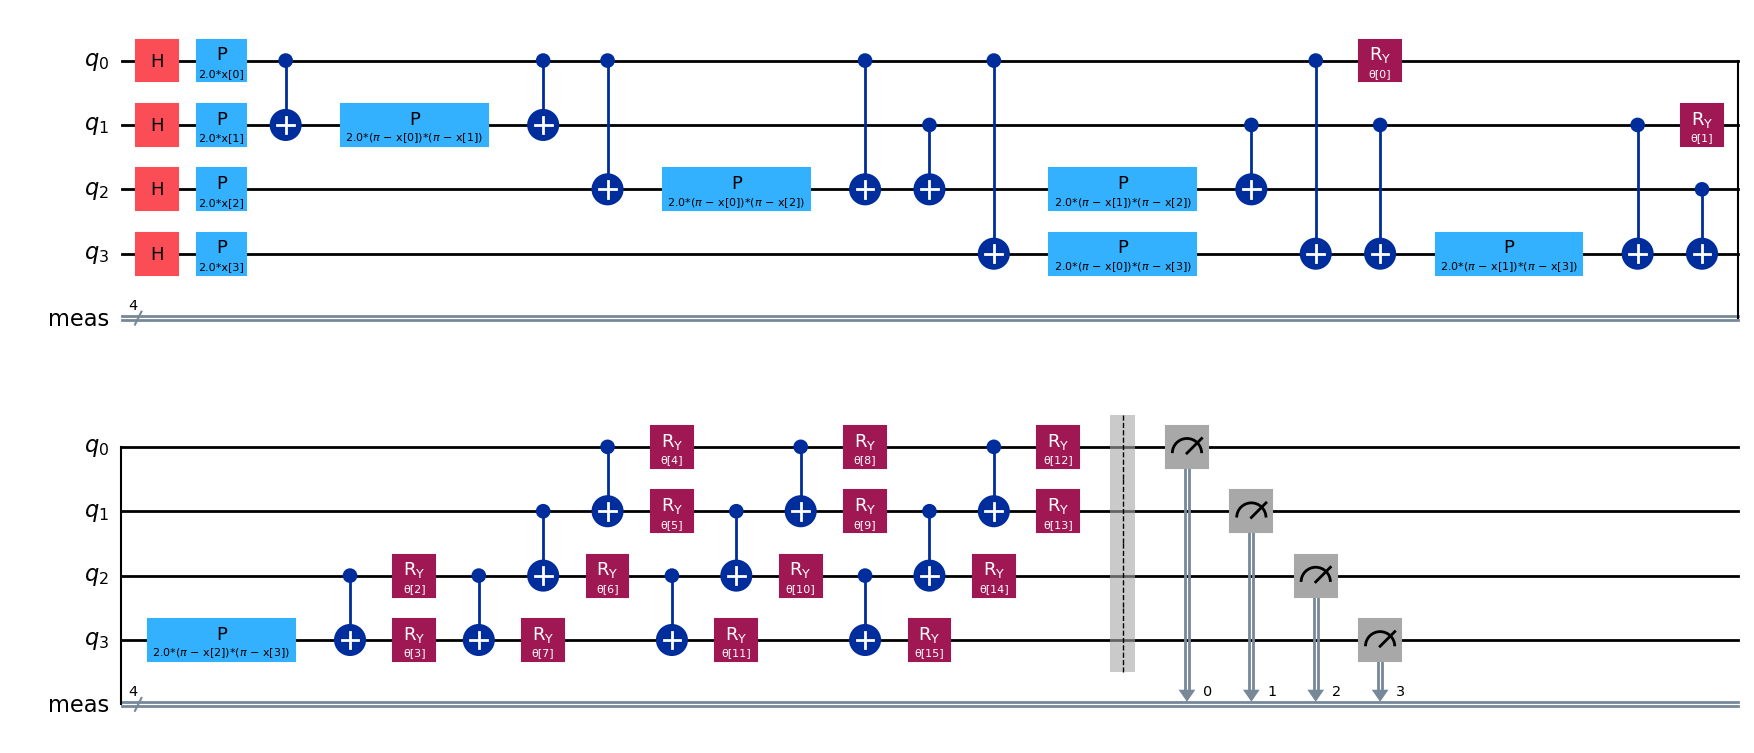

In [13]:
circuit = feature_map.compose(ansatz)
circuit.decompose().draw(output='mpl',filename='overallcircuit.png')

In [14]:
initial_point = np.random.random(ansatz.num_parameters)
initial_point

array([0.71663775, 0.29688609, 0.35532166, 0.63358973, 0.97662896,
       0.36972224, 0.92715793, 0.06234144, 0.97408482, 0.55767782,
       0.97977294, 0.87870853, 0.34278528, 0.29075727, 0.20688414,
       0.24839119])

In [15]:
encoder = OneHotEncoder()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1,1)).toarray()

In [23]:
vqc = VQC(feature_map=feature_map,
         ansatz=ansatz,
         loss='cross_entropy',
         optimizer=SPSA(),
         initial_point=initial_point)

In [24]:
vqc.fit(train_features, train_labels_oh)

In [25]:
print(f'Quantum VQC test accuracy: {vqc.score(test_features, test_labels_oh):.2f}')

Quantum VQC test accuracy: 0.84
